# Data pre-processing

In [16]:
# Import required packages
import pandas as pd
import numpy as np

In [17]:
# Load data from provided files

# calendar: 1969 days from 29th Jan 2011 - 19th June 2016
# prices: 185260 rows, weekly prices for 823 food items (labelled 1 to 827)
# sales_train: daily sales from day 1 to day 1913
# sales_test: daily sales from day 1914 to day 1941

calendar = pd.read_csv('../data/calendar_afcs2023.csv')
sell_prices = pd.read_csv('../data/sell_prices_afcs2023.csv')
sales_train_data = pd.read_csv('../data/sales_train_validation_afcs2023.csv')
sales_test_data = pd.read_csv('../data/sales_test_validation_afcs2022.csv')

In [18]:
# Merge calendar with weekly sell prices for all food items
calendar_prices = pd.merge(left=calendar, right=sell_prices, how='left', on='wm_yr_wk')

# Add d_i key
calendar_prices['date'] = pd.to_datetime(calendar_prices['date'])
calendar_prices['d'] = [f'd_{day}' for day in (calendar_prices['date'] - pd.to_datetime('2011-01-28')).dt.days]

# Rearrange train and test data, so it can be merged with the calendar data
sales_train = sales_train_data.copy()
sales_train['id'] = sales_train['id'].str.replace('_TX_3_validation','')
sales_train_stack = sales_train.set_index('id').stack().reset_index()
sales_train_stack.columns = ['item_id', 'd', 'sales']

# Add data for sales previous day
sales_train_stack['sales_prev_day'] = sales_train_stack['sales'].shift(1)
sales_train_stack.loc[sales_train_stack['d']=='d_1', 'sales_prev_day'] = np.nan

# Repeat for the test set
sales_test = sales_test_data.copy()
sales_test['id'] = sales_test['id'].str.replace('_TX_3_validation','')
sales_test_stack = sales_test.set_index('id').stack().reset_index()
sales_test_stack.columns = ['item_id', 'd', 'sales']

# Merge calender with train and test data
calendar_train = pd.merge(left=calendar_prices, right=sales_train_stack, how='left', on=['item_id', 'd'])
calendar_train = calendar_train.dropna(subset=['sales']).drop(columns=['store_id','d'])

calendar_test = pd.merge(left=calendar_prices, right=sales_test_stack, how='left', on=['item_id', 'd'])
calendar_test = calendar_test.dropna(subset=['sales']).drop(columns=['store_id','d'])


In [19]:
# Save to CSV file to transfer to R
calendar_test.to_csv('test_data.csv', index=False)
calendar_train.to_csv('train_data.csv', index=False)

# EDA

In [20]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns

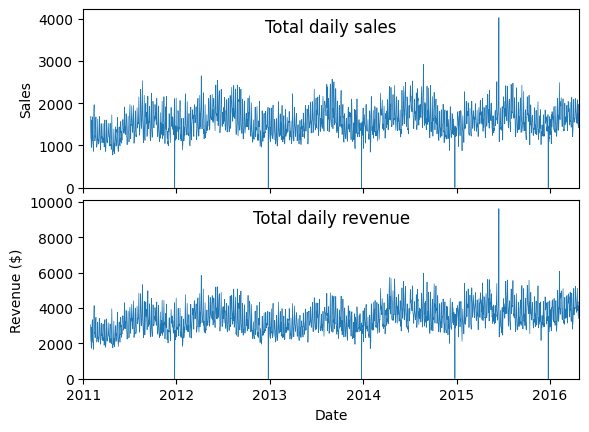

In [21]:
# Add product revenue
calendar_train['revenue'] = calendar_train['sales'] * calendar_train['sell_price']

# Aggregate daily sales
total_daily_sales = calendar_train.groupby('date')['sales'].sum()
total_daily_revenue = calendar_train.groupby('date')['revenue'].sum()

# Plot both sales and revenue
ax1 = plt.subplot(211)
plt.plot(total_daily_sales, linewidth=0.5)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylim(0)
plt.ylabel('Sales')
plt.title('Total daily sales', y=0.87, pad=0)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(total_daily_revenue, linewidth=0.5)
plt.ylim(0)
plt.ylabel('Revenue ($)')
plt.xlabel('Date')
plt.title('Total daily revenue', y=0.87, pad=0)
plt.xlim(pd.to_datetime('2011-01-01'), total_daily_sales.index.max())

plt.subplots_adjust(hspace=0.07)

#plt.savefig('Sales_revenue.png', dpi=600, bbox_inches='tight')

# Massive sales June 15 2015 (unknown reason, check if one product)
# Closed on Christmas day
# No trend, monthly and weekly seasonality for sales
# Very slight upwards trend for revenue (inflation)
print()

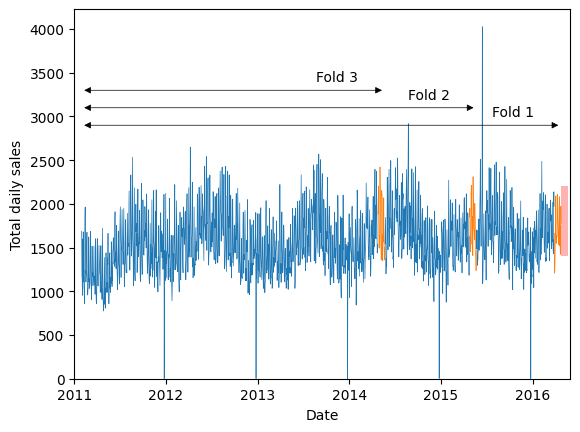

In [22]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

# Plot sales displaying train/validation split
total_daily_sales_v = total_daily_sales.to_frame()

valid1 = (total_daily_sales_v.index >= '2016-03-28') & (total_daily_sales_v.index <= '2016-04-24')
valid2 = (total_daily_sales_v.index >= '2015-04-25') & (total_daily_sales_v.index <= '2015-05-22')
valid3 = (total_daily_sales_v.index >= '2014-04-25') & (total_daily_sales_v.index <= '2014-05-22')

total_daily_sales_v['valid'] = 0
total_daily_sales_v.loc[total_daily_sales_v.index >= '2014-04-25','valid'] = 2
total_daily_sales_v.loc[total_daily_sales_v.index >= '2015-04-25','valid'] = 1


total_daily_sales_v.loc[valid1,'valid'] = 10
total_daily_sales_v.loc[valid2,'valid'] = 20
total_daily_sales_v.loc[valid3,'valid'] = 30

sns.lineplot(data=total_daily_sales_v, x= total_daily_sales_v.index, y='sales',
             hue='valid', linewidth = 0.5, palette=["C0","C0","C0", "C1", "C1", "C1"], legend=None)
plt.ylabel('Total daily sales')
plt.xlabel('Date')
plt.ylim(0)
plt.xlim(pd.to_datetime('2011-01-01'), pd.to_datetime('2016-05-31') )

# Create rectangle x coordinates
start = mdates.date2num(pd.to_datetime('2016-04-25'))
end = mdates.date2num(pd.to_datetime('2016-05-22'))
width = end - start

# Plot rectangle
rect = Rectangle((start, 1400), width, 800, color='red', alpha=0.3, edgecolor=None, linewidth=0)
ax = plt.gca()
ax.add_patch(rect)

# Add annotations to indicate folds
arrow_style = dict(arrowstyle= '<|-|>', color='black', lw=0.5, ls='-')

plt.annotate('', xy=(mdates.date2num(pd.to_datetime('2011-01-29')), 2900),
             xytext=(mdates.date2num(pd.to_datetime('2016-04-24')), 2900),
             arrowprops=arrow_style)
plt.annotate('', xy=(mdates.date2num(pd.to_datetime('2011-01-29')), 3100),
             xytext=(mdates.date2num(pd.to_datetime('2015-05-22')), 3100),
             arrowprops=arrow_style)
plt.annotate('', xy=(mdates.date2num(pd.to_datetime('2011-01-29')), 3300),
             xytext=(mdates.date2num(pd.to_datetime('2014-05-22')), 3300),
             arrowprops=arrow_style)

plt.annotate('Fold 1', xy=(mdates.date2num(pd.to_datetime('2015-07-24')), 3000))
plt.annotate('Fold 2', xy=(mdates.date2num(pd.to_datetime('2014-08-22')), 3200))
plt.annotate('Fold 3', xy=(mdates.date2num(pd.to_datetime('2013-08-22')), 3400))

#plt.savefig('Sales_validation_plot.png', dpi=600, bbox_inches='tight')

print()

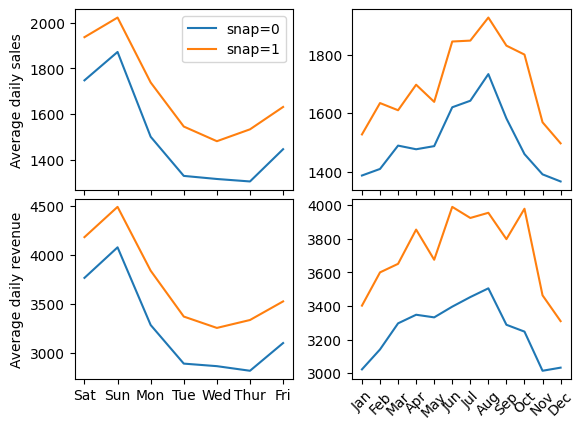

In [23]:
# Plot weekly average and monthly average total sales (remove products with zeros)

daily_sales_revenue = calendar_train.groupby(['date']).agg(
    {'snap_TX':'mean', 'wday': 'mean', 'month': 'mean', 
     'sales': 'sum', 'revenue': 'sum'})

weekly_sales = daily_sales_revenue.groupby(['snap_TX','wday'])['sales'].mean()
monthly_sales = daily_sales_revenue.groupby(['snap_TX','month'])['sales'].mean()
weekly_rev = daily_sales_revenue.groupby(['snap_TX','wday'])['revenue'].mean()
monthly_rev = daily_sales_revenue.groupby(['snap_TX','month'])['revenue'].mean()

fig = plt.figure()
# Plot both sales and revenue
ax1 = plt.subplot(221)
plt.plot(range(7), weekly_sales[0], label='snap=0')
plt.plot(range(7), weekly_sales[1], label='snap=1')
plt.xticks(ticks=range(7), labels=['Sat','Sun','Mon','Tue','Wed','Thur','Fri'])
plt.ylabel('Average daily sales')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(range(7), weekly_rev[0], label=0)
plt.plot(range(7), weekly_rev[1], label=1)
plt.xticks(ticks=range(7), labels=['Sat','Sun','Mon','Tue','Wed','Thur','Fri'])
plt.ylabel('Average daily revenue')

ax3 = plt.subplot(222)
plt.plot(range(12), monthly_sales[0], label=0)
plt.plot(range(12), monthly_sales[1], label=1)
plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(224, sharex=ax3)
plt.plot(range(12), monthly_rev[0], label=0)
plt.plot(range(12), monthly_rev[1], label=1)
plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)

# Highest sales/revenue Saturday and Sunday. Lowest sales Tuesday, Wednesday, Thursday.
# Highest sales June-July-August (summer), Lowest Oct-Apr (winter)
plt.subplots_adjust(wspace=0.27, hspace=0.05)

#plt.savefig('Sales_revenue_week_year.png', dpi=600, bbox_inches='tight')

print()

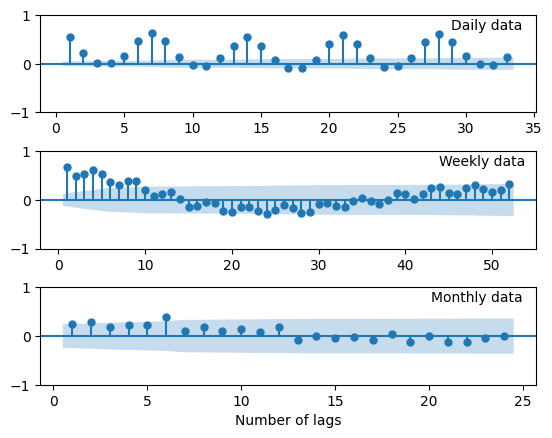

In [24]:
# Create ACF plots

# ACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(3)
# fig.suptitle('Autocorrelation (total sales)', y=0.95)
daily_lags = plot_acf(calendar_train.groupby('date')['sales'].sum(), ax=ax[0], zero=False)
ax[0].set_title('Daily data', size=10, x=0.9, y=0.85, pad=0)
weekly_lags = plot_acf(calendar_train.groupby('wm_yr_wk')['sales'].sum(), ax=ax[1], lags=52, zero=False)
ax[1].set_title('Weekly data', size=10, x=0.89, y=0.85, pad=0)
monthly_lags = plot_acf(calendar_train.groupby(['month','year'])['sales'].sum(), ax=ax[2], lags=24, zero=False)
ax[2].set_title('Monthly data', size=10, x=0.88, y=0.85, pad=0)

plt.xlabel('Number of lags')
plt.subplots_adjust(hspace=0.4)

#plt.savefig('Sales_autocorrelation.png', dpi=600, bbox_inches='tight')

# Very strong weekly seasonality on daily autocorrelation
# Yearly seasonality data also present, but less statistically significant


In [25]:
# Calculate impact of the various events

daily_sales_events = calendar_train.fillna('None').groupby(['date']).agg(
    {'wday': 'mean', 'month': 'mean', 
     'sales': 'sum', 'sales_prev_day': 'sum', 
     'event_name_1':'max', 'event_type_1':'max', 'event_name_2':'max', 'event_type_2':'max'})

percent_diff = dict()

event_names = np.unique(np.hstack((daily_sales_events['event_name_1'], daily_sales_events['event_name_2'])))

for event in event_names:
    
    event_type = daily_sales_events[(daily_sales_events['event_name_1']==event)]['event_type_1'].iloc[0]
    
    event_days = daily_sales_events[(daily_sales_events['event_name_1']==event) | (daily_sales_events['event_name_2']==event) ]  
    
    weekdays = event_days['wday'].unique()
    months = event_days['month'].unique()
    
    average_sales_during_event = event_days['sales'].mean()
    average_sales_during_event_prev = event_days['sales_prev_day'].iloc[1:].mean()
    
    non_events_idx = (daily_sales_events['event_name_1']=='None') & \
                     (daily_sales_events['wday'].isin(weekdays)) & \
                     (daily_sales_events['month'].isin(months))
    
    average_sales_during_nonevent = daily_sales_events.loc[non_events_idx,'sales'].mean()
    average_sales_during_nonevent_prev = daily_sales_events.iloc[1:].loc[non_events_idx[1:],'sales_prev_day'].mean()
    
    same_day_sales =(average_sales_during_event / average_sales_during_nonevent - 1) * 100
    prev_day_sales = (average_sales_during_event_prev / average_sales_during_nonevent_prev - 1) * 100
        
    percent_diff[event] = [same_day_sales, prev_day_sales, event_type]


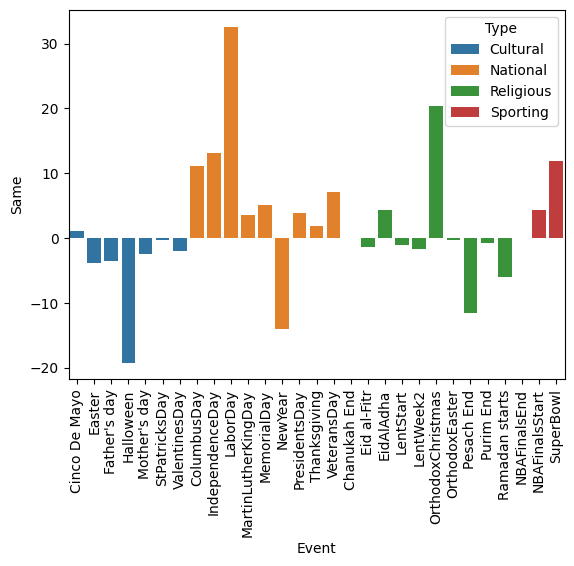

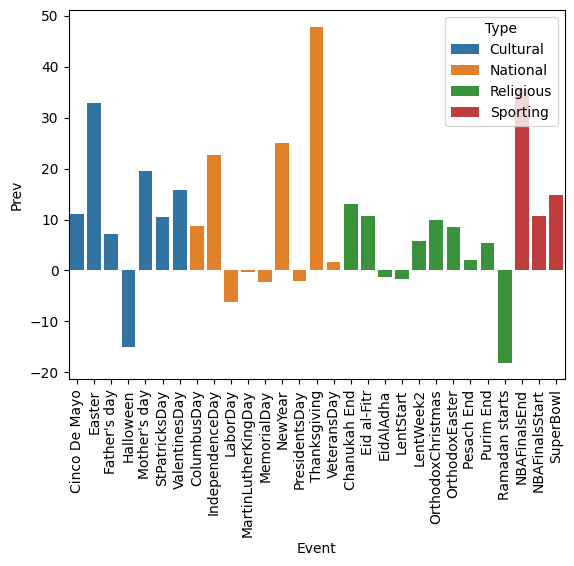

In [26]:
# Plot impact of events

event_impacts = pd.DataFrame(percent_diff).T.reset_index()
event_impacts.columns = ['Event', 'Same', 'Prev', 'Type']
event_impacts = event_impacts.sort_values(by=['Type','Event'])

plt.figure()
plot1 = sns.barplot(data=event_impacts[(event_impacts['Event']!='Christmas')&(event_impacts['Type']!='None')], 
                    x='Event', y='Same', hue='Type')
plt.xticks(rotation=90)

plt.figure()
plot2 = sns.barplot(data=event_impacts[(event_impacts['Event']!='Christmas')&(event_impacts['Type']!='None')], 
                    x='Event', y='Prev', hue='Type')
plt.xticks(rotation=90)

print()


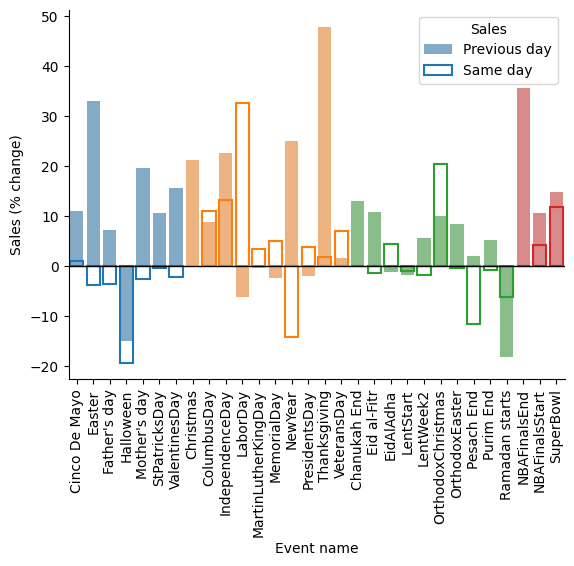

In [27]:
# Plot both same day and previous sales on same bar plot

melt = event_impacts[(event_impacts['Type']!='None')].melt(id_vars=['Event','Type'])
melt['key'] = melt['Type'] + ' - ' + melt['variable']
melt = melt.sort_values(by=['Type', 'Event', 'variable'])

fig = plt.figure()
sns.barplot(x='Event', y='value', hue='Type', data=melt[melt['variable']=='Prev'], alpha=0.6, legend=False)
sns.barplot(x='Event', y='value', hue='Type', data=melt[(melt['variable']=='Same')&(melt['Event']!='Christmas')], fill=False, linewidth=1.5, legend=False)

sns.despine(fig)
plt.xticks(rotation=90)
plt.axhline(0, color='k', linewidth=1.0)
plt.xlabel('Event name')
plt.ylabel('Sales (% change)')

dummy1 = melt.copy().iloc[0:1]
dummy1.columns = ['Event','Type','Sales','value','key']
dummy1['value'] = np.nan
dummy1['Sales'] = 'Previous day'

dummy2 = melt.copy().iloc[1:2]
dummy2.columns = ['Event','Type','Sales','value','key']
dummy2['value'] = np.nan
dummy2['Sales'] = 'Same day'

sns.barplot(x='Event', y='value', hue='Sales', data=dummy1, alpha=0.6)
sns.barplot(x='Event', y='value', hue='Sales', data=dummy2, fill=False, linewidth=1.5)

print()

#plt.savefig('Sales_events.png', dpi=600, bbox_inches='tight')

(0.0, 1950.0)

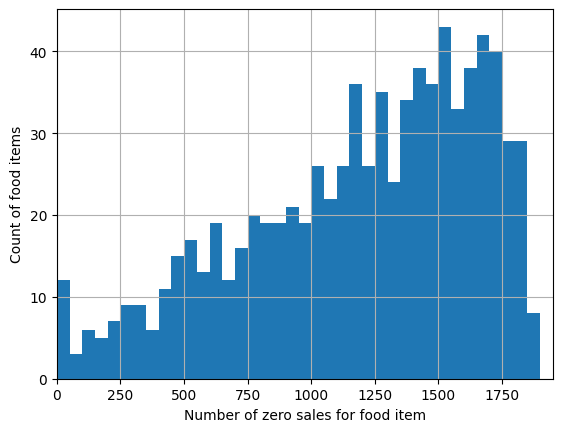

In [28]:
# Check zero values

data = sales_train_data.set_index('id')
counts = (data==0).T.sum()

binwidth=50
counts.hist(bins=range(0, 1950 + binwidth, binwidth))
plt.xlabel('Number of zero sales for food item')
plt.ylabel('Count of food items')
plt.xlim(0,1950)
#plt.savefig('Sales_histogram_zero.png', dpi=600, bbox_inches='tight')
